# 12/26/23 - This notebook tests the modules "space_jam" and "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.switch_backend('agg')
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

In [3]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']

In [58]:
obj_name = obj_names[1]
SN = 15
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='cyl'
zlens= zlenses[slacs_ix_table['Name']==obj_name]
zsource = zsources[slacs_ix_table['Name']==obj_name]
cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
p0 = np.array([2.2, 0.7, 0.9, 1.5, 0.5, 7]) # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = np.array([[2.15, 0.65, 0.0, 1.35, 0.0, 6 ], 
                  [2.25, 0.75, 1.0, 1.5, 1.0, 8]])
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
nstep = 100
nwalkers = 12
ndim = 6
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 2

welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                 obj_name, SN, mass_model, anisotropy, geometry, align, 
                                zlens, zsource, cosmo, fast_slow,
                               p0, bounds, sigpar, prior_type, lensprior, 
                               sampler_args, date_time, run_id, plot=False, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)


Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942_2024_01_31_v2/

qobs_min  0.65
q_intr lower bound from qobs_min  0.3424632235585689
minimum inclination from qobs_min  6.3922755085446425
Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.2  0.74 0.9  1.5  0.5  7.  ]


In [59]:
welcome_to_the_jam.qobs_eff

0.7001641320830052

In [60]:
welcome_to_the_jam.sigmapsf

0.2388078047701601

In [61]:
welcome_to_the_jam.sigmapsf = 0.39373654928679985 # from my psf refitting

In [62]:
welcome_to_the_jam.sigmapsf*2.355

0.9272495735704136

In [63]:
welcome_to_the_jam.sigmapsf

0.39373654928679985

In [64]:
welcome_to_the_jam.run_mcmc()

Started Emcee please wait...
Progress is printed periodically


100%|██████████| 100/100 [1:52:57<00:00, 58.55s/it]


n accepted unique parameters 536
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942_2024_01_31_v2/SDSSJ0037-0942_2024_01_31_v2_space_jam.pkl
Job's finished!


In [65]:
%matplotlib inline

In [66]:
welcome_to_the_jam.save_space_jam()

Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942_2024_01_31_v2/SDSSJ0037-0942_2024_01_31_v2_space_jam.pkl


I need to change the function index_accepted_samples. It is resulting in 1212 instead of 1200 values

In [67]:
#################
# function to identify where samples were updated (accepted) vs rejected, so I can index the "anisotropy_ratio_samples" etc. properly                              
def index_accepted_samples(self):
    
    # create an array of the indices that are to be accepted for each of the steps
    self.index_accepted = np.zeros(self.pars.shape[0], dtype=int)
    
    # every step includes the initial state
    every_step = np.concatenate((self.initial_state, self.sampler.flatchain))
    nwalkers = self.sampler_args[1]
    
    # loop through each of hte walkers individually
    for i in range(nwalkers):
        # this walker will be every "nwalkers" of the parameters
        this_walker = every_step[i::nwalkers]
        # start with the initial state, it will be replaced by the first one that was accepted
        last_accepted_state = this_walker[0]
        # start with the index of the initial state
        last_accepted_index = i
        # loop through the steps of this walker
        for j, index in enumerate(this_walker):
            # skip the initialization
            if j==0:
                continue
            # if the walker is not equal to the last accepted state, then a new sample was accepted
            # the param_index is the index of the parameter in the shape nwalkers*nsteps
            param_index = (j-1)*nwalkers+i
            # the replace_index is the index of the "lambda_int" samples, shape (nwalkers+1)*nsteps to include the initial state
            replace_index = j*nwalkers+i
            if np.all(this_walker[j] != last_accepted_state):
                # report this index to the array
                self.index_accepted[param_index] = replace_index
                last_accepted_state = this_walker[j]
                last_accepted_index = replace_index
            else:
                self.index_accepted[(j-1)*nwalkers+i] = last_accepted_index
                
    # save the accepted lambda_int and anisotropy
    self.anisotropy_ratio_accepted = np.zeros(self.pars.shape[0], dtype=float)
    self.lambda_int_accepted = np.zeros(self.pars.shape[0], dtype=float)
    # loop through the steps
    for i in range(self.pars.shape[0]):
        self.anisotropy_ratio_accepted[i] = self.anisotropy_ratio_samples[self.index_accepted[i]]
        self.lambda_int_accepted[i] = self.lambda_int_samples[self.index_accepted[i]]

In [68]:
import types

In [69]:
welcome_to_the_jam.index_accepted_samples = types.MethodType(index_accepted_samples, welcome_to_the_jam)

In [70]:
welcome_to_the_jam.index_accepted_samples()

(array([  2.,   5.,  19.,  76.,  84., 179., 240., 194., 111.,  57.]),
 array([0.87063393, 0.88350941, 0.89638489, 0.90926037, 0.92213585,
        0.93501134, 0.94788682, 0.9607623 , 0.97363778, 0.98651327,
        0.99938875]),
 <a list of 10 Patch objects>)

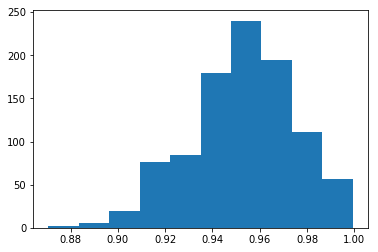

In [71]:
plt.hist(welcome_to_the_jam.anisotropy_ratio_accepted[~np.isnan(welcome_to_the_jam.anisotropy_ratio_accepted)])

In [72]:
###################
# function to plot summary
def summary_plot(self, save=False):

    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.
    """

    # jam the best fit
    jam, surf_potential, lambda_int = self.jam_lnprob(self.bestfit, plot=True, test_prior=False, bestfit=True)
    plt.pause(1)
    if jam==0:
        return 'Cannot plot this bestfit'
    rms_model = jam.model
    flux_model = jam.flux

    plot_pars = self.pars.copy()
    plot_bounds = np.array(bounds).copy()#self.bounds.copy()
    plot_truths = self.p0.copy()
    #truths should only be for gamma, theta_E and q_intr
    plot_truths[2] = 0
    plot_truths[-1] = 0
    plot_truths[-2] = 0
    # substitute the plot parameters with the ratios and lambda_ints
    plot_pars[:,2] = self.anisotropy_ratio_accepted
    plot_pars[:,-2] = self.lambda_int_accepted
    # bounds should change
    plot_bounds[0][2] = self.shape_anis_bounds[0]
    plot_bounds[1][2] = self.shape_anis_bounds[1]
    plot_bounds[0][-2] = 0.8
    plot_bounds[1][-2] = 1.2

    # calculate uncertainties in posterior
    plot_bestfit = plot_pars[np.nanargmax(self.lnprob)]
    print('bestfit', plot_bestfit)
    perc = np.percentile(plot_pars, [15.86, 84.14], axis=0)  # 68% interval
    sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
    chi2_bestfit = self.chi2s[self.index_accepted][np.nanargmax(self.lnprob)]

    # For plotting, only show the finite probability points
    finite = np.isfinite(self.lnprob)

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(plot_pars[finite], self.lnprob[finite], labels=self.labels, extents=plot_bounds, truths=plot_truths, truth_color='k', fignum=1)

    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()

    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {np.around(chi2_bestfit, 2)}', (0.30, 0.97-(1+len(self.labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(self.labels, plot_bestfit, sig_bestfit):
        string = f"{label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1

    # plot circular reff
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = self.Vrms.copy()
    rms1[self.goodbins] = symmetrize_velfield(self.xbin[self.goodbins], self.ybin[self.goodbins], self.Vrms[self.goodbins])
    vmin, vmax = np.percentile(rms1[self.goodbins], [0.5, 99.5])
    plot_velfield(self.xbin, self.ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    # plot circular reff again... can only patch one time
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(self.xbin, self.ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    #plt.tick_params(labelbottom=False)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    if save==True:
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.png', bbox_inches='tight')
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.pdf', bbox_inches='tight')

    plt.show()
    plt.pause(1)

In [73]:
welcome_to_the_jam.summary_plot = types.MethodType(summary_plot, welcome_to_the_jam)

In [74]:
# adamet
#from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import corner
#from IPython.display import display, Math
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.plot_velfield import plot_velfield

[2.15297767 0.63248157 0.63691359 1.48373175 0.85689339 7.72024492]


/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


1.0185549915315575


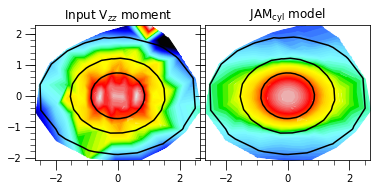

bestfit [2.15297767 0.63248157 0.94982943 1.48373175 1.01855499 7.72024492]


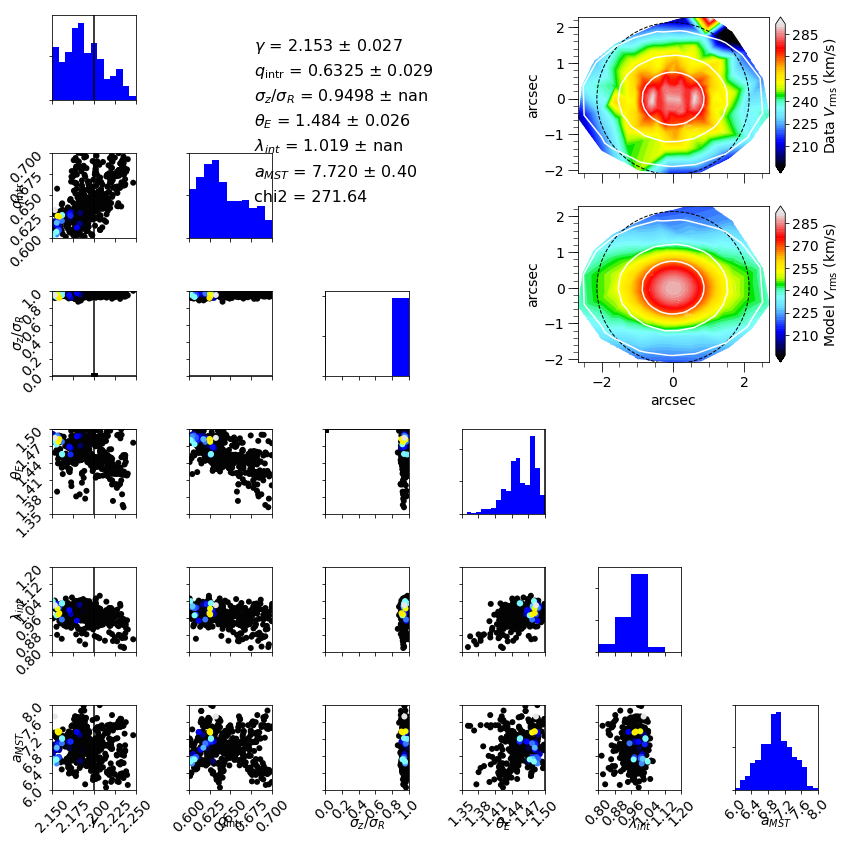

In [75]:
welcome_to_the_jam.summary_plot()

In [76]:
welcome_to_the_jam.calculate_inclination_from_qintr_eff(0.69621881)

84.06498674856057

In [77]:
welcome_to_the_jam.anisotropy_ratio_from_k_and_q_intr(0.1511, 0.6926)

0.9031410801493492

______________________________

In [23]:
welcome_to_the_jam.pars[:,0]

array([2.1806972 , 2.18437699, 2.20668109, 2.22129642, 2.22175738,
       2.16470687, 2.23691943, 2.18243833, 2.22691354, 2.19911245,
       2.15219013, 2.15416542, 2.19347843, 2.18437699, 2.20668109,
       2.22129642, 2.2195043 , 2.16470687, 2.23691943, 2.17607426,
       2.22691354, 2.19911245, 2.15219013, 2.15416542])

In [24]:
welcome_to_the_jam.bestfit

array([2.17607426, 0.67706001, 0.98405259, 1.48879679, 0.72639288,
       6.82499659])

In [25]:
welcome_to_the_jam.pars[np.nanargmax(welcome_to_the_jam.lnprob)]

array([2.17607426, 0.67706001, 0.98405259, 1.48879679, 0.72639288,
       6.82499659])

In [26]:
welcome_to_the_jam.jam_lnprob

<bound method space_jam.jam_lnprob of <space_jam.space_jam object at 0x7eff45f567f0>>

In [27]:
welcome_to_the_jam.bounds

array([[2.15      , 0.6       , 0.        , 1.35      , 0.        ,
        6.        ],
       [2.25      , 0.70016413, 1.        , 1.5       , 1.        ,
        8.        ]])

In [28]:
nwalkers=12
nsteps=100

indices = np.zeros(nsteps)
last_true = 0
for i in range(nwalkers):
    for , index in enumerate(welcome_to_the_jam.index_accepted[::nwalkers]):
    if i == 0:
        continue
    if index == True:
        indices[i-1] = i
        last_true = i
    else:
        indices[i-1] = last_true

SyntaxError: invalid syntax (<ipython-input-28-fa03ddcac407>, line 7)

In [ ]:
    every_step = np.concatenate((self.initial_state, self.sampler.flatchain))
    nwalkers = self.sampler_args[1]

    for i in range(nwalkers):
        this_walker = every_step[i::nwalkers]
        accepted_state = this_walker[0]
        for j in range(len(this_walker)-1):
            if np.all(this_walker[j] != accepted_state):
                self.index_accepted[(j+1)*nwalkers+i] = 1
                accepted_state = this_walker[j]
            else:
                self.index_accepted[j*nwalkers+i] = 1

In [ ]:
indices

In [ ]:
welcome_to_the_jam.lambda_int_samples.shape

In [ ]:
welcome_to_the_jam.anisotropy_ratio_samples.shape

In [ ]:
welcome_to_the_jam.pars.shape

In [ ]:
welcome_to_the_jam.index_accepted[welcome_to_the_jam.index_accepted].shape

In [ ]:
welcome_to_the_jam.bestfit

# Previous one

In [ ]:
welcome_to_the_jam.bestfit

In [ ]:
welcome_to_the_jam.bounds